In [19]:
# install libraries and packages
# !pip install geopandas
# !pip install fiona
# !pip install rioxarray
# !pip install rasterio
# !pip install rasterstats
# %pip install "folium>=0.12" matplotlib mapclassify
# %pip install libpysal esda
# %pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import libpysal
import esda
import statsmodels.api as sm
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display

# Save grid dataframes (10km, 25km, 50km, and 100km cell sizes)

This cell loads your four grid layers (10km, 25km, 50km, 100km) from the same GeoPackage and makes sure they all use the same projected coordinate system (ESRI:102022) so measurements like area work correctly. It first prints the list of layers inside the GeoPackage to confirm the names are correct. Then it reads each grid layer into Python and reprojects it to ESRI:102022. After that, it adds two useful fields to each grid: a unique ID for every cell (cell_id) and the cell’s area in square kilometers (area_km2). Finally, it draws the outlines of the 100km grid to visually confirm the grid looks right, and shows the first few rows so you can check that the new columns were added successfully.

Layers: ['africa_grid_10km', 'africa_grid_25km', 'africa_grid_50km', 'africa_grid_100km']


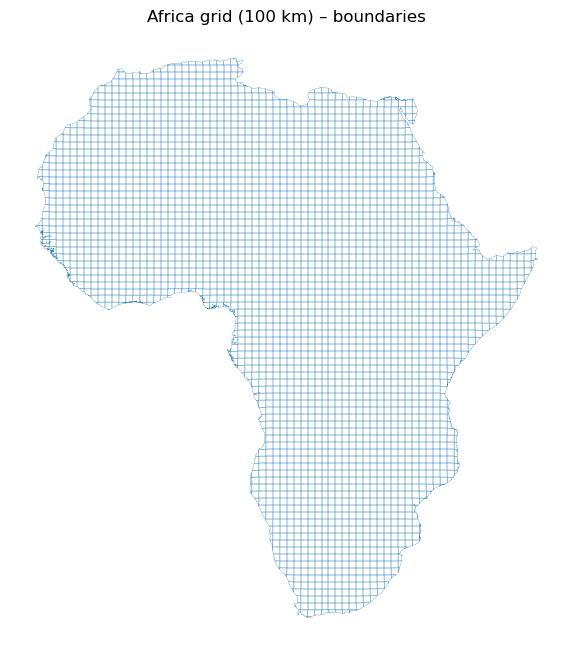

id          left           top         right        bottom  row_index  \
0  16 -4.440354e+06  2.594190e+06 -4.340354e+06  2.494190e+06         15   
1  17 -4.440354e+06  2.494190e+06 -4.340354e+06  2.394190e+06         16   
2  18 -4.440354e+06  2.394190e+06 -4.340354e+06  2.294190e+06         17   
3  19 -4.440354e+06  2.294190e+06 -4.340354e+06  2.194190e+06         18   
4  23 -4.440354e+06  1.894190e+06 -4.340354e+06  1.794190e+06         22   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4379925.239 2512293.782, -437...        0   
1          0  MULTIPOLYGON (((-4383777.578 2395504.385, -438...        1   
2          0  MULTIPOLYGON (((-4340462.002 2350585.846, -434...        2   
3          0  MULTIPOLYGON (((-4340370.242 2202587.665, -434...        3   
4          0  MULTIPOLYGON (((-4340354.478 1801073.221, -434...        4   

      area_km2  
0  1470.721709  
1  5608.520868  
2  1516.129525  
3    19.280008  
4    12.852028

In [2]:
# import all grid versions in EPSG:102022
layers = fiona.listlayers("data/Africa_grid_102022.gpkg")
print("Layers:", layers)
grid_10km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_10km").to_crs("ESRI:102022")
grid_25km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_25km").to_crs("ESRI:102022")
grid_50km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_50km").to_crs("ESRI:102022")
grid_100km = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_100km").to_crs("ESRI:102022")

# Save dataframe for each grid
def add_id_area(gdf):
    gdf = gdf.reset_index(drop=True)
    gdf["cell_id"] = gdf.index.astype("int64")
    gdf["area_km2"] = gdf.geometry.area / 1e6  # m² -> km²
    return gdf
grid_10km  = add_id_area(grid_10km)
grid_25km  = add_id_area(grid_25km)
grid_50km  = add_id_area(grid_50km)
grid_100km = add_id_area(grid_100km)

# Visualize grid cells
fig, ax = plt.subplots(figsize=(8, 8))
grid_100km.boundary.plot(ax=ax, linewidth=0.2)
ax.set_title("Africa grid (100 km) – boundaries")
ax.set_axis_off()
plt.show()

# Show dataframe
grid_100km.head()

----------

# Compute counts of conflict incidents per grid cell

----------

This cell calculates how many ACLED conflict events fall inside each grid cell, and then stores that count as a new column in the grid. It starts by loading the ACLED points (which are in latitude/longitude) and reprojecting them into the same projected CRS as the grid (ESRI:102022) so the layers line up correctly. Next, it fixes any invalid grid polygons so the spatial operations don’t fail. Then it does a spatial join so every conflict point is matched to the grid cell it falls inside, counts how many points matched each cell, and attaches those counts back onto the grid. Cells with no events are filled with 0. At the end it prints quick checks (total points, matched, unmatched, and the summed grid counts) to confirm nothing was lost, and it runs the same process for the 10km, 25km, 50km, and 100km grids so each grid version gets its own incident-count column.

### Total conflict incidents

In [3]:
def compute_conflictincidents_aggregated(grid):
    # import ACLED conflict data (EPSG:4326)
    conflict_data = gpd.read_file("data/ACLED_conflict-data_africa_2020-2024_4326.gpkg")
    conflict_data = conflict_data.to_crs("ESRI:102022")
    
    # fix any invalid grid geometries
    grid["geometry"] = grid.geometry.make_valid()
    
    # spatial join: each point gets the cell_id it falls in
    pts_with_cellid = gpd.sjoin(conflict_data[["geometry"]],grid[["cell_id", "geometry"]],how="left",predicate="within") # predicate="within" avoids double-counting boundary points, but may drop exact-on-boundary cases
    
    # count points per cell_id
    incident_counts = pts_with_cellid.groupby("cell_id").size().rename("incident_count")
    
    # join back to grid; fill empty with zero
    grid = grid.join(incident_counts, on="cell_id")
    grid["incident_count"] = grid["incident_count"].fillna(0).astype("int64")
    
    # check unmatched points (if high consider changing to predicate="intersects"
    print("Total ACLED points:", len(conflict_data))
    print("Matched to a cell:", pts_with_cellid["cell_id"].notna().sum())
    print("Unmatched:", pts_with_cellid["cell_id"].isna().sum())
    print("Grid sum incidents:", grid["incident_count"].sum())

    return grid

grid_10km = compute_conflictincidents_aggregated(grid_10km)
grid_25km = compute_conflictincidents_aggregated(grid_25km)
grid_50km = compute_conflictincidents_aggregated(grid_50km)
grid_100km = compute_conflictincidents_aggregated(grid_100km)

grid_10km.head()

Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140
Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140
Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140
Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140


id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  incident_count  
0  40.913185               5  
1  32.444992              11  
2   0.357439               0  
3  69.284336              36  
4   9.327453             280

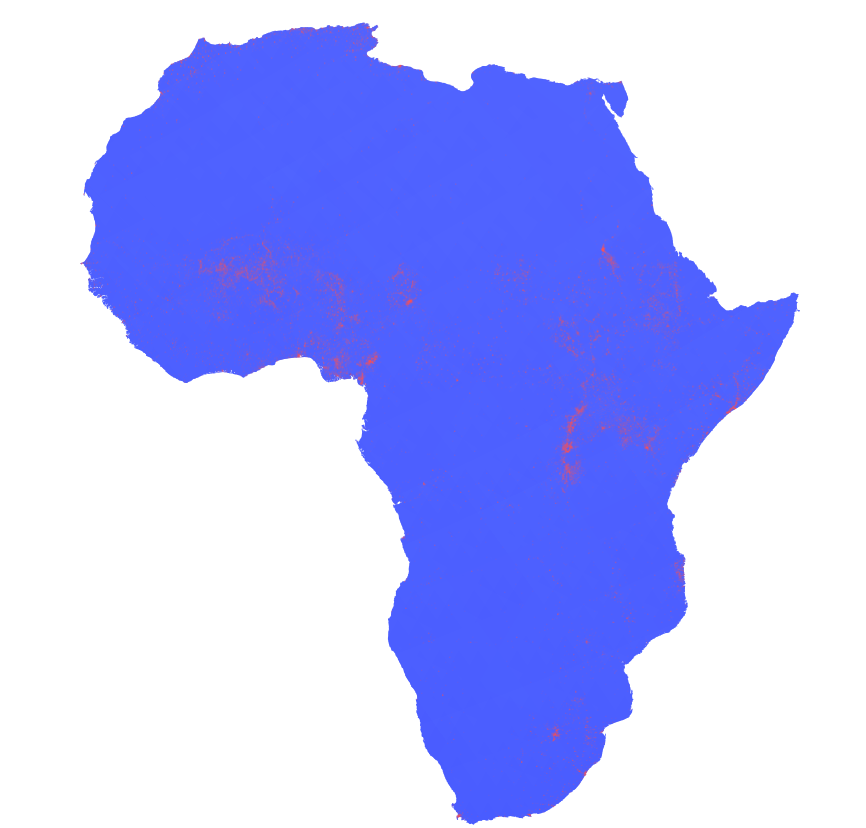

In [4]:
display(IPyImage(filename="screenshots/Count_violence_all.png"))

### Disaggregated counts by incident type

This cell goes one step further than a single total count by calculating separate counts for each type of conflict event inside every grid cell. It loads the ACLED points and reprojects them to match the grid so the layers align, then fixes any invalid grid polygons. Next, it assigns each ACLED point to the grid cell it falls within (spatial join), but this time it keeps the event category field as well. It then counts points by (grid cell, event type) and reshapes the results so each event type becomes its own column (for example, one column for battles, one for protests, etc.). The code also cleans up the column names so they are consistent and easy to use later, joins these new event-type columns back onto the grid, replaces missing values with zeros (meaning “no events of this type in this cell”), and finally creates a count_total column by summing across all event-type columns so you still have an overall total for each cell.

In [5]:
def compute_conflictincidents_disaggregated(grid):
    # import ACLED conflict data (EPSG:4326)
    conflict_data = gpd.read_file("data/ACLED_conflict-data_africa_2020-2024_4326.gpkg")
    conflict_data = conflict_data.to_crs("ESRI:102022")
    # fix any invalid grid geometries
    grid["geometry"] = grid.geometry.make_valid()
    
    # 1) spatial join (keep EVENT_TYPE + cell_id)
    pts = gpd.sjoin(conflict_data[["EVENT_TYPE", "geometry"]],grid[["cell_id", "geometry"]],how="left",predicate="within")
    
    # 2) counts per cell per event type -> wide columns
    counts_wide = (pts.groupby(["cell_id", "EVENT_TYPE"]).size().unstack(fill_value=0))
    
    # 3) clean column names
    counts_wide.columns = ["count_" + str(c).lower().replace("/", "_").replace(" ", "_").replace("-", "_") for c in counts_wide.columns]
    
    # 4) join to grid (safe overwrite if re-running)
    grid = grid.drop(columns=counts_wide.columns, errors="ignore")
    grid = grid.join(counts_wide, on="cell_id")
    
    # 5) fix nans
    event_cols = counts_wide.columns.tolist()
    grid[event_cols] = grid[event_cols].fillna(0).astype("int64")
    
    # 6) compute total
    grid["count_total"] = grid[event_cols].sum(axis=1).astype("int64")
    
    # Check counts
    grid[[c for c in grid.columns if c.startswith("cnt_")]].sum().sort_values(ascending=False)

    return grid

grid_10km = compute_conflictincidents_disaggregated(grid_10km)
grid_25km = compute_conflictincidents_disaggregated(grid_25km)
grid_50km = compute_conflictincidents_disaggregated(grid_50km)
grid_100km = compute_conflictincidents_disaggregated(grid_100km)

grid_10km.head()

id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  incident_count  count_battles  count_explosions_remote_violence  \
0  40.913185               5              0                                 0   
1  32.444992              11              0                                 0   
2   0.357439               0              0                                 0   
3  69.284336              36              0                                 0   
4   9.327453             280              1                                 0   

   count_protests  count_riots  count_strategic_developments  \
0               2            2                             1   
1               4            6                             1   
2               0            0                             0   
3               9           22                             4   
4             126           98                            48   

   count_violence_against_civilians  count_total  
0                                 0            5  
1                                 0           11  
2                                 0            0  
3                                 1           36  
4                                 7          280

----------

# Compute estimated population per grid cell

----------

This cell estimates the total population inside each grid cell using a population density raster. It loads the population density GeoTIFF and checks what value represents “no data” so missing pixels are handled correctly. Because the raster is in latitude/longitude and the grid is in a projected CRS, the raster is reprojected into the same CRS as the grid so pixel sizes are in meters and pixel areas are consistent. The code then converts density values into “people per pixel” by multiplying the density by the pixel’s area (converted to km²). After that, it calculates population per grid cell by summing the “people per pixel” values inside each polygon. Since there are many grid cells, it processes them in chunks to avoid running out of memory or locking up the notebook. Finally, it rounds the results to whole people, saves them in a new pop_est column, and repeats the same population-estimation workflow for the 10km, 25km, 50km, and 100km grid layers.

In [6]:
def compute_population_estimate(grid):    
    # use population density raster to estimate population based on grid cell area size
    popdens = rxr.open_rasterio("data/GPW_popdensity_africa_4326.tif", masked=True).squeeze()
    
    nodata = popdens.rio.nodata
    if nodata is None:
        nodata = -9999
    print("Using nodata:", nodata)
    
    popdens_aea = popdens.rio.reproject(grid.crs,resolution=5000,resampling=Resampling.average,nodata=nodata)
    
    px_w, px_h = popdens_aea.rio.resolution()
    pixel_area_km2 = abs(px_w * px_h) / 1e6
    people_per_pixel = popdens_aea * pixel_area_km2
    
    grid["pop_est"] = 0.0
    chunk_size = 5000
    
    for start in range(0, len(grid), chunk_size):
        chunk = grid.iloc[start:start+chunk_size]
        zs = zonal_stats(chunk,np.asarray(people_per_pixel.values),affine=people_per_pixel.rio.transform(),nodata=nodata,stats=["sum"],all_touched=False)
        grid.loc[chunk.index, "pop_est"] = [d["sum"] if d["sum"] is not None else 0 for d in zs]
    
    grid["pop_est"] = grid["pop_est"].round().astype("int64")

    return grid

grid_10km = compute_population_estimate(grid_10km)
grid_25km = compute_population_estimate(grid_25km)
grid_50km = compute_population_estimate(grid_50km)
grid_100km = compute_population_estimate(grid_100km)
    
grid_10km.head()

Using nodata: nan
Using nodata: nan
Using nodata: nan
Using nodata: nan


id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  incident_count  count_battles  count_explosions_remote_violence  \
0  40.913185               5              0                                 0   
1  32.444992              11              0                                 0   
2   0.357439               0              0                                 0   
3  69.284336              36              0                                 0   
4   9.327453             280              1                                 0   

   count_protests  count_riots  count_strategic_developments  \
0               2            2                             1   
1               4            6                             1   
2               0            0                             0   
3               9           22                             4   
4             126           98                            48   

   count_violence_against_civilians  count_total  pop_est  
0                                 0            5   153048  
1                                 0           11   229572  
2                                 0            0        0  
3                                 1           36   229572  
4                                 7          280        0

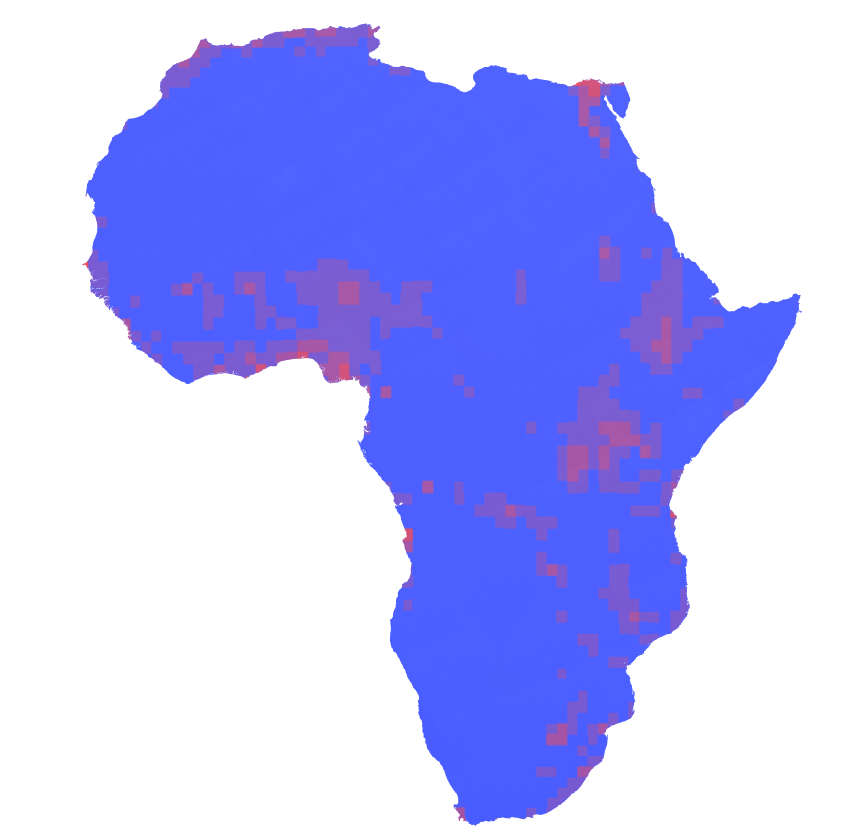

In [7]:
display(IPyImage(filename="screenshots/Control_population.png"))

-----

# Compute paved road kilometers per grid cell

-----

This cell calculates how many kilometers of roads fall inside each grid cell. It starts by loading the roads layer (stored in latitude/longitude) and then reprojects both the roads and the grid into a distance-friendly CRS (ESRI:102023) so that road lengths are measured in meters and can be converted to kilometers. It removes any missing or empty line geometries and fixes invalid shapes so the overlay operation won’t fail. Next, it intersects the roads with the grid so each road is “cut” into smaller segments that fit inside individual grid cells. It measures the length of each clipped segment, converts meters to kilometers, and then sums those segment lengths for each grid cell. Finally, it attaches the result back onto the original grid as a new road_km column, filling empty cells with 0 (meaning no roads in that cell), and runs the same procedure for the 10km, 25km, 50km, and 100km grids.

In [8]:
def compute_pavedroadkm(grid):
    # import roads and reproject to equidistant crs
    roads = gpd.read_file("data/Africa_roads_4326.gpkg")
    crs_len = "ESRI:102023"
    roads_len = roads.to_crs(crs_len)
    grid_len = grid.to_crs(crs_len)
    
    # keep only line geometries; drop empties
    roads_len = roads_len[roads_len.geometry.notna()].copy()
    roads_len = roads_len[~roads_len.geometry.is_empty].copy()
    
    # fix invalid geometries
    roads_len["geometry"] = roads_len.geometry.make_valid()
    grid_len["geometry"] = grid_len.geometry.make_valid()
    
    # spatial index overlay (intersection) creates road segments clipped to each cell polygon
    roads_x = gpd.overlay(roads_len[["geometry"]],grid_len[["cell_id", "geometry"]],how="intersection",keep_geom_type=True)
    
    # length in km
    roads_x["road_km"] = roads_x.geometry.length / 1000.0
    
    # sum per cell
    road_km_by_cell = roads_x.groupby("cell_id")["road_km"].sum()
    
    # write back onto main grid_10km (in 102022) by cell_id
    grid["road_km"] = grid["cell_id"].map(road_km_by_cell).fillna(0.0)

    return grid

grid_10km = compute_pavedroadkm(grid_10km)
grid_25km = compute_pavedroadkm(grid_25km)
grid_50km = compute_pavedroadkm(grid_50km)
grid_100km = compute_pavedroadkm(grid_100km)

grid_10km.head()

id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  incident_count  count_battles  count_explosions_remote_violence  \
0  40.913185               5              0                                 0   
1  32.444992              11              0                                 0   
2   0.357439               0              0                                 0   
3  69.284336              36              0                                 0   
4   9.327453             280              1                                 0   

   count_protests  count_riots  count_strategic_developments  \
0               2            2                             1   
1               4            6                             1   
2               0            0                             0   
3               9           22                             4   
4             126           98                            48   

   count_violence_against_civilians  count_total  pop_est    road_km  
0                                 0            5   153048  12.537470  
1                                 0           11   229572  16.945375  
2                                 0            0        0   0.000000  
3                                 1           36   229572   6.069887  
4                                 7          280        0  13.382641

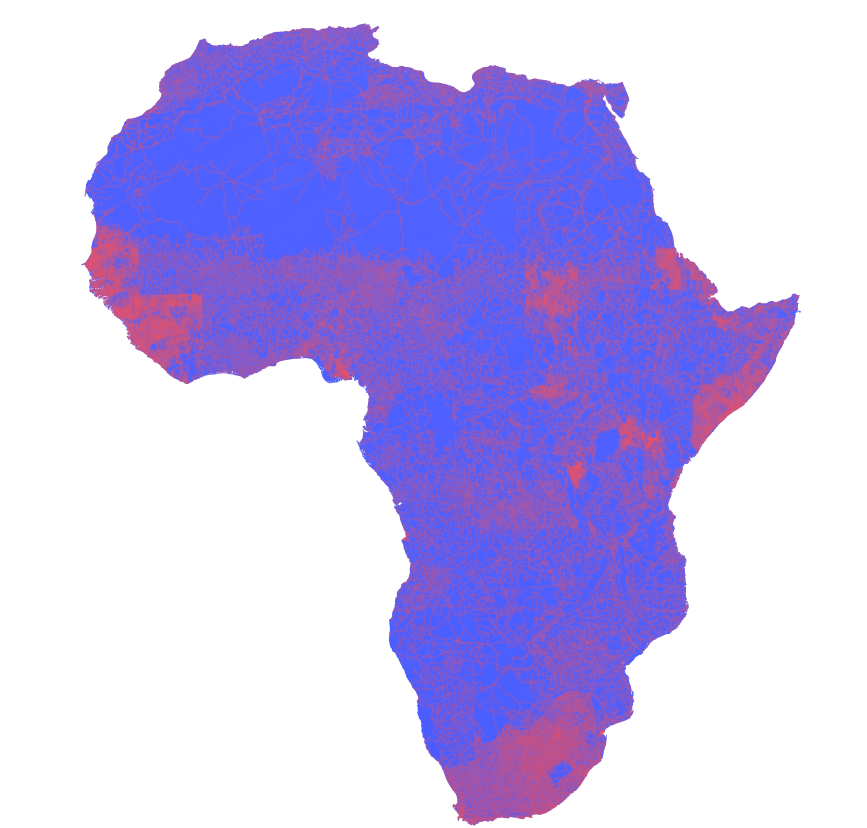

In [9]:
display(IPyImage(filename="screenshots/Control_roads.png"))

-----

# Identify coastal cells

-----

This cell creates a simple “coastal cell” flag for each grid cell. The idea is that when you clip a square grid to the Africa land polygon, interior cells stay full-sized squares, but cells along the coastline get cut off and end up with a smaller area. The code defines a small function that compares each cell’s area_km2 to the expected full area for that grid size (for example, 10km × 10km = 100 km²). If a cell’s area is noticeably smaller than the full size (using a small tolerance to avoid floating-point quirks), it assigns is_coastal = 1; otherwise it assigns is_coastal = 0. It then runs that same rule for the 10km, 25km, 50km, and 100km grids using the appropriate full-cell area values, so each grid version gets a consistent coastal/non-coastal indicator.

In [10]:
def coastal_binary(grid, set_cell_area):
    # full cell area in km^2 (10km x 10km)
    full_area_km2 = set_cell_area
    tol = 0.01
    grid["is_coastal"] = (grid["area_km2"] < (full_area_km2 - tol)).astype("int64")
    return grid

grid_10km = coastal_binary(grid_10km, 100)
grid_25km = coastal_binary(grid_25km, 625)
grid_50km = coastal_binary(grid_50km, 2500)
grid_100km = coastal_binary(grid_100km, 10000)

grid_10km.head()

id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  ...  count_battles  count_explosions_remote_violence  \
0  40.913185  ...              0                                 0   
1  32.444992  ...              0                                 0   
2   0.357439  ...              0                                 0   
3  69.284336  ...              0                                 0   
4   9.327453  ...              1                                 0   

   count_protests  count_riots  count_strategic_developments  \
0               2            2                             1   
1               4            6                             1   
2               0            0                             0   
3               9           22                             4   
4             126           98                            48   

   count_violence_against_civilians  count_total  pop_est    road_km  \
0                                 0            5   153048  12.537470   
1                                 0           11   229572  16.945375   
2                                 0            0        0   0.000000   
3                                 1           36   229572   6.069887   
4                                 7          280        0  13.382641   

   is_coastal  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 21 columns]

-----

# LISA Moran Clusters

-----

This cell computes spatial autocorrelation for the conflict totals and assigns each grid cell a LISA cluster label (HH, HL, LH, or LL). It starts by making a copy of the grid, fixing any invalid polygons, and replacing missing values in count_total with zero so every cell can be included. Because conflict counts are extremely skewed (many zeros and a few hotspots), it applies a log transform (log1p) so the autocorrelation results are not dominated by a small number of extreme values. Next, it builds a spatial “neighbors” structure using Queen contiguity, meaning each cell is considered a neighbor if it touches another cell by an edge or even a corner, and then row-standardizes those weights. The code then calculates Global Moran’s I to summarize whether the entire map shows clustering overall, and Local Moran’s I (LISA) to identify where clustering happens cell-by-cell. Finally, it converts each cell’s LISA quadrant into a human-readable cluster label (HH, HL, LH, LL), and optionally marks cells as “Not signif” when the local p-value is above the chosen significance level, so the final output can be mapped as cluster categories rather than raw statistics.

def compute_autocorrelation(grid):
    gdf = grid.copy()
    
    # validate geometry
    gdf["geometry"] = gdf.geometry.make_valid()
    
    # fill nans with 0s
    gdf["count_total"] = gdf["count_total"].fillna(0).astype(float)
    
    # Log count for skewed
    y = np.log1p(gdf["count_total"].to_numpy())
    # For raw counts instead, use:
    # y = gdf["count_total"].to_numpy()
    
    # 1) Spatial weights: Queen contiguity (polygon neighbors sharing edge or vertex)
    w = libpysal.weights.Queen.from_dataframe(gdf)
    w.transform = "r"  # row-standardize
    
    # 2) Global Moran's I
    mi = esda.Moran(y, w, permutations=999)
    print("Global Moran's I:", mi.I)
    print("p-value (sim):", mi.p_sim)
    
    # 3) Local Moran (LISA)
    li = esda.Moran_Local(y, w, permutations=999)
    gdf["lisa_I"] = li.Is
    gdf["lisa_p"] = li.p_sim
    gdf["lisa_q"] = li.q  # quadrant 1..4
    
    # 4) Quadrant mapping (PySAL convention):
    quad_map = {1: "HH", 2: "LH", 3: "LL", 4: "HL"}
    gdf["lisa_label"] = gdf["lisa_q"].map(quad_map)
    alpha = 0.05
    gdf.loc[gdf["lisa_p"] > alpha, "lisa_label"] = "Not signif"
    
    return gdf

grid_10km = compute_autocorrelation(grid_10km)
grid_25km = compute_autocorrelation(grid_25km)
grid_50km = compute_autocorrelation(grid_50km)
grid_100km = compute_autocorrelation(grid_100km)

grid_10km.head()

-----

# Compute distance between cell centroid and nearest border (national, colonial, religious, ethnic)

-----

This cell adds a “distance to border” variable for each grid cell, which you can use as a key predictor in your regression. It defines a reusable function that takes a grid layer and a specific border dataset (national, colonial, religious, or ethnic) and then computes the distance from each cell’s centroid to the nearest border line. The function loads the border lines, creates centroid points from the grid cells, and reprojects both the centroids and the borders into a distance-friendly projected CRS (ESRI:102023) so the distance results are in meters. It also cleans the border data by removing empty geometries and fixing invalid shapes to prevent spatial errors. Next, it uses a “nearest neighbor” spatial join to find the closest border feature to each centroid and records that distance. Because ties or duplicated matches can happen, it collapses the results so that each grid cell keeps one distance value (the minimum distance). Finally, it attaches the distance back onto the grid as new columns—one in meters and one converted to kilometers—so you end up with a consistent distance-to-border metric for each grid cell and for each type of border you run through the function.

In [11]:
def compute_dist_to_border(gdf, border_name, file):
    #import borders data
    borders = gpd.read_file(file)
    #print("Borders CRS:", borders.crs)
    
    # set target crs for distance calculations in meters
    crs_dist = "ESRI:102023"
    
    # compute centroids
    centroids = gdf[["cell_id", "geometry"]].copy()
    centroids["geometry"] = centroids.geometry.centroid
    
    # make sure both grid and border data are in crs for distance calculation
    centroids = centroids.to_crs(crs_dist)
    borders = borders.to_crs(crs_dist)
    
    # drop empties + make valid
    borders = borders[borders.geometry.notna() & ~borders.geometry.is_empty].copy()
    borders["geometry"] = borders.geometry.make_valid()
    
    # nearest border + distance (uses spatial index)
    nearest = gpd.sjoin_nearest(centroids,borders[["geometry"]],how="left",distance_col=f"dist_{border_name}_m"
    )
    
    # attach back to grid (in your original CRS) ---- FIXED
    dist_by_cell = nearest.groupby("cell_id")[f"dist_{border_name}_m"].min()  # one value per cell_id
    gdf[f"dist_{border_name}_m"] = gdf["cell_id"].map(dist_by_cell.to_dict())
    gdf[f"dist_{border_name}_km"] = gdf[f"dist_{border_name}_m"] / 1000.0
    
    return gdf

#10km grid
grid10km = compute_dist_to_border(grid_10km, "national_border", "data/africa_national-borders_102023.gpkg")
grid10km = compute_dist_to_border(grid_10km, "colonial_border", "data/africa_colonial-borders_102023.gpkg")
grid10km = compute_dist_to_border(grid_10km, "religious_border", "data/africa_religion-borders_102023.gpkg")
grid10km = compute_dist_to_border(grid_10km, "ethnic_border", "data/africa_ethnic-borders_102023.gpkg")
#25km grid
grid25km = compute_dist_to_border(grid_25km, "national_border", "data/africa_national-borders_102023.gpkg")
grid25km = compute_dist_to_border(grid_25km, "colonial_border", "data/africa_colonial-borders_102023.gpkg")
grid25km = compute_dist_to_border(grid_25km, "religious_border", "data/africa_religion-borders_102023.gpkg")
grid25km = compute_dist_to_border(grid_25km, "ethnic_border", "data/africa_ethnic-borders_102023.gpkg")
#50km grid
grid50km = compute_dist_to_border(grid_50km, "national_border", "data/africa_national-borders_102023.gpkg")
grid50km = compute_dist_to_border(grid_50km, "colonial_border", "data/africa_colonial-borders_102023.gpkg")
grid50km = compute_dist_to_border(grid_50km, "religious_border", "data/africa_religion-borders_102023.gpkg")
grid50km = compute_dist_to_border(grid_50km, "ethnic_border", "data/africa_ethnic-borders_102023.gpkg")
#100km grid
grid100km = compute_dist_to_border(grid_100km, "national_border", "data/africa_national-borders_102023.gpkg")
grid100km = compute_dist_to_border(grid_100km, "colonial_border", "data/africa_colonial-borders_102023.gpkg")
grid100km = compute_dist_to_border(grid_100km, "religious_border", "data/africa_religion-borders_102023.gpkg")
grid100km = compute_dist_to_border(grid_100km, "ethnic_border", "data/africa_ethnic-borders_102023.gpkg")

grid10km.head()

id          left           top         right        bottom  row_index  \
0   241 -4.440354e+06  1.694190e+06 -4.430354e+06  1.684190e+06        240   
1   242 -4.440354e+06  1.684190e+06 -4.430354e+06  1.674190e+06        241   
2  1042 -4.430354e+06  1.704190e+06 -4.420354e+06  1.694190e+06        239   
3  1043 -4.430354e+06  1.694190e+06 -4.420354e+06  1.684190e+06        240   
4  1044 -4.430354e+06  1.684190e+06 -4.420354e+06  1.674190e+06        241   

   col_index                                           geometry  cell_id  \
0          0  MULTIPOLYGON (((-4438668.496 1685614.099, -444...        0   
1          0  MULTIPOLYGON (((-4431485.105 1676494.905, -443...        1   
2          1  MULTIPOLYGON (((-4420354.478 1694991.355, -442...        2   
3          1  MULTIPOLYGON (((-4422310.661 1685092.152, -442...        3   
4          1  MULTIPOLYGON (((-4430237.063 1683369.85, -4429...        4   

    area_km2  ...    road_km  is_coastal  dist_national_border_m  \
0  40.913185  ...  12.537470           1           152394.064255   
1  32.444992  ...  16.945375           1           155389.434713   
2   0.357439  ...   0.000000           1           138095.879609   
3  69.284336  ...   6.069887           1           145226.850131   
4   9.327453  ...  13.382641           1           152508.784180   

   dist_national_border_km  dist_colonial_border_m  dist_colonial_border_km  \
0               152.394064             2109.304064                 2.109304   
1               155.389435             2075.714919                 2.075715   
2               138.095880              188.593302                 0.188593   
3               145.226850             2997.363708                 2.997364   
4               152.508784              643.191903                 0.643192   

   dist_religious_border_m  dist_religious_border_km  dist_ethnic_border_m  \
0              2232.800685                  2.232801           2009.456483   
1              1895.840424                  1.895840           1975.326218   
2               221.962177                  0.221962            288.678909   
3              3090.083073                  3.090083           2897.184534   
4               155.808369                  0.155808            542.933016   

   dist_ethnic_border_km  
0               2.009456  
1               1.975326  
2               0.288679  
3               2.897185  
4               0.542933  

[5 rows x 29 columns]

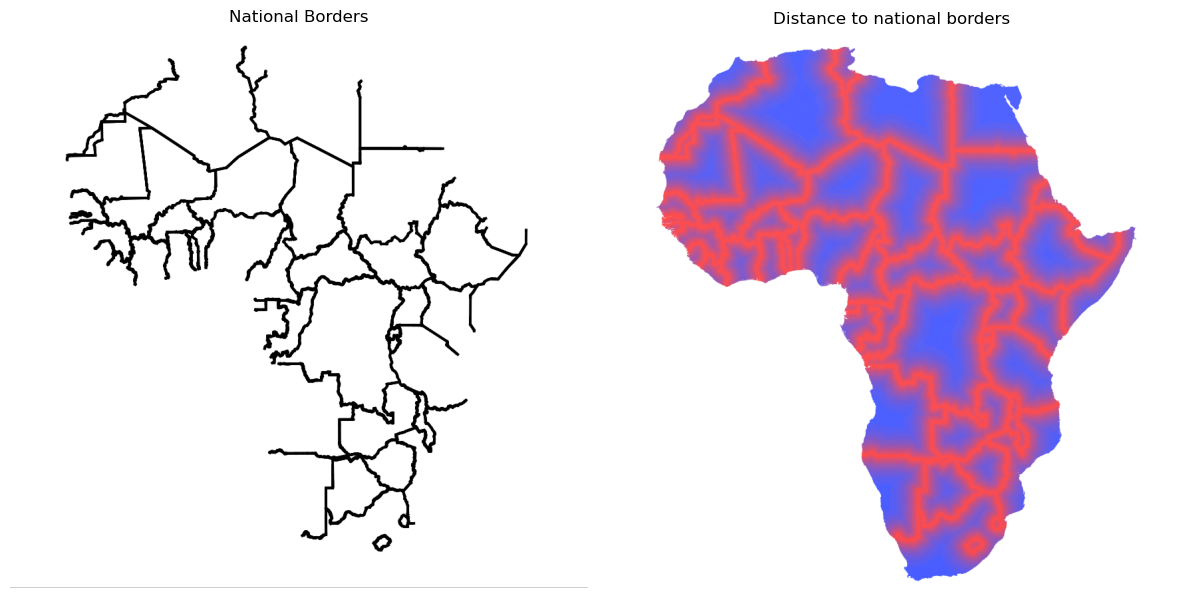

In [12]:
img1 = PILImage.open("screenshots/Lines-national-borders.png")
img2 = PILImage.open("screenshots/Dist-national-borders.png")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis("off")
axes[0].set_title("National Borders")
axes[1].imshow(img2)
axes[1].axis("off")
axes[1].set_title("Distance to national borders")
plt.tight_layout()
plt.show()

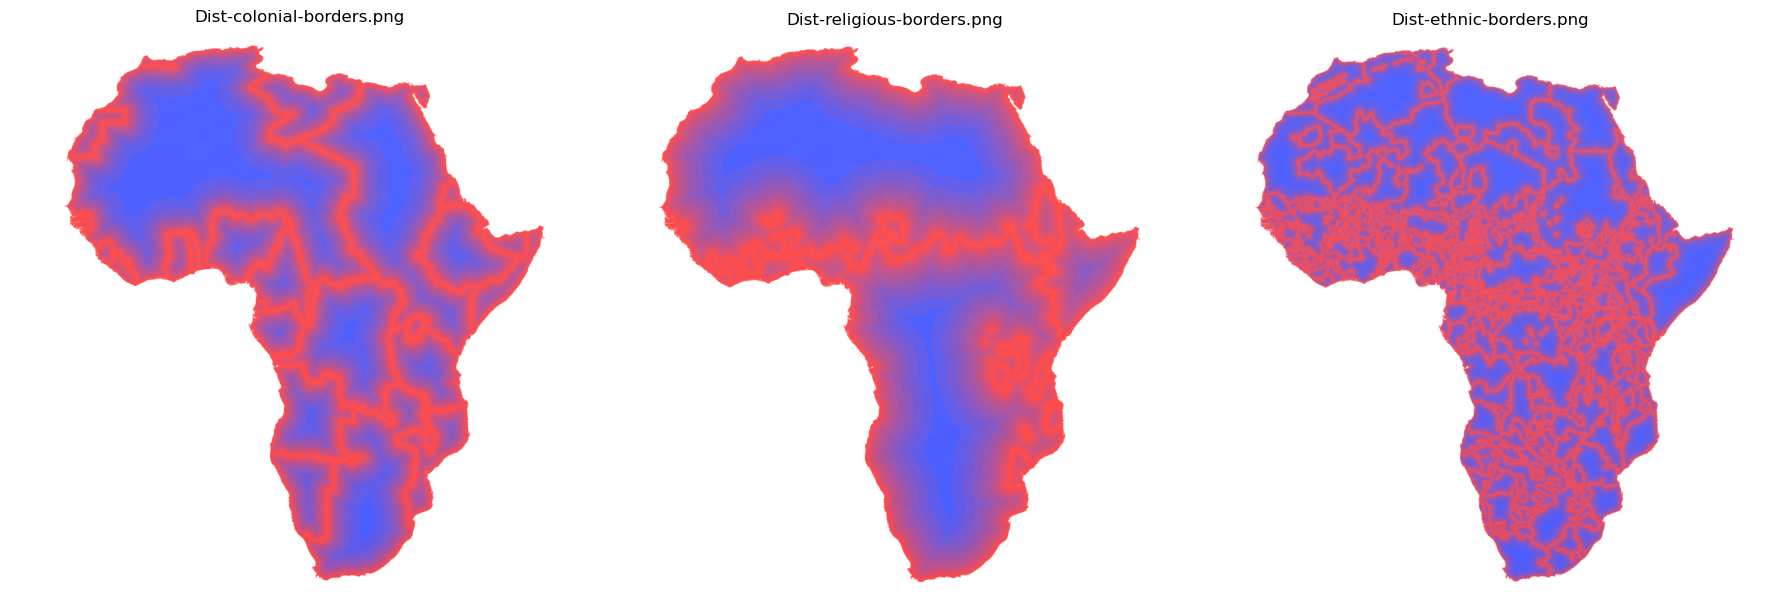

In [13]:
paths = ["screenshots/Dist-colonial-borders.png","screenshots/Dist-religious-borders.png","screenshots/Dist-ethnic-borders.png",]
imgs = [PILImage.open(p) for p in paths]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, img, title in zip(axes, imgs, [p.split("/")[-1] for p in paths]):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)
plt.tight_layout()
plt.show()

-----

# Export to geopackage for regression analysis notebook

-----

In [14]:
# save each grid resolution as layer to geopackage
grid_10km.to_file("africa_grid_stats.gpkg", layer="africa_grid_10km_stats", driver="GPKG")
grid_25km.to_file("africa_grid_stats.gpkg", layer="africa_grid_25km_stats", driver="GPKG")
grid_50km.to_file("africa_grid_stats.gpkg", layer="africa_grid_50km_stats", driver="GPKG")
grid_100km.to_file("africa_grid_stats.gpkg", layer="africa_grid_100km_stats", driver="GPKG")

-----

# Linear Regression

-----

In [20]:
def run_ols_for_border(gdf, dist_col, use_log_y=True):
    df = gdf[[dist_col, "count_total", "pop_est", "road_km", "is_coastal"]].copy()

    # basic cleaning
    df = df.dropna(subset=[dist_col])
    df[["count_total", "pop_est", "road_km", "is_coastal"]] = df[["count_total", "pop_est", "road_km", "is_coastal"]].fillna(0)

    # dependent variable
    y = np.log1p(df["count_total"]) if use_log_y else df["count_total"].astype(float)

    # predictors (include intercept)
    X = df[[dist_col, "pop_est", "road_km", "is_coastal"]].astype(float)
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit(cov_type="HC1")  # robust SEs
    return model

dist_cols = [c for c in grid_10km.columns if c.startswith("dist_") and c.endswith("_km")]
dist_cols


['dist_national_border_km',
 'dist_colonial_border_km',
 'dist_religious_border_km',
 'dist_ethnic_border_km']

In [21]:
models = {}
for c in dist_cols:
    models[c] = run_ols_for_border(grid_10km, c, use_log_y=True)
    print("\n" + "="*80)
    print(c)
    print(models[c].summary().tables[1])


dist_national_border_km
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0404      0.003     15.455      0.000       0.035       0.046
dist_national_border_km    -0.0002   5.64e-06    -30.230      0.000      -0.000      -0.000
pop_est                  7.064e-06   2.35e-07     30.048      0.000     6.6e-06    7.53e-06
road_km                     0.0069      0.000     24.109      0.000       0.006       0.008
is_coastal                  0.1463      0.013     11.534      0.000       0.121       0.171

dist_colonial_border_km
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0148      0.003      5.166      0.000       0.009       0.020
dist_colonial_border_km -1.015

-----

# Considerations for further controls

-----

# Land Cover

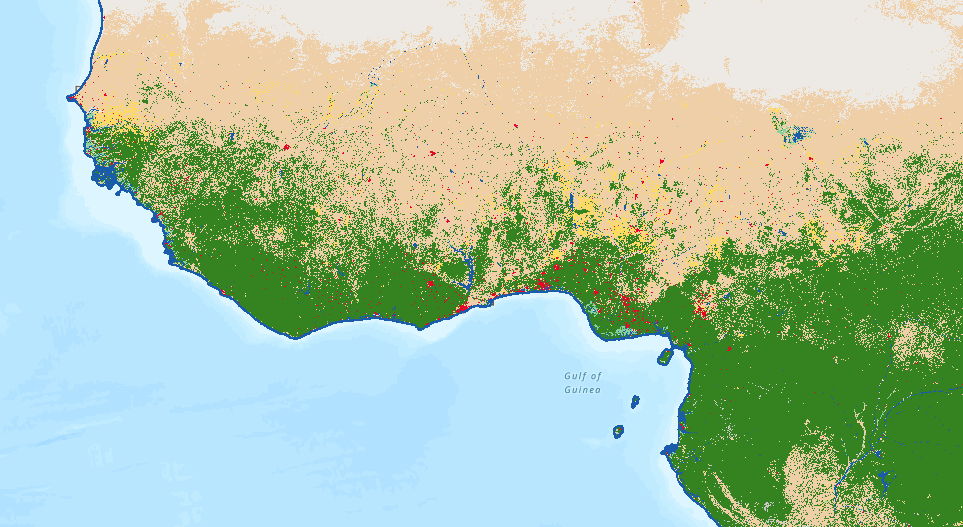

In [15]:
display(IPyImage(filename="screenshots/Control_landcover.png"))

### Rivers

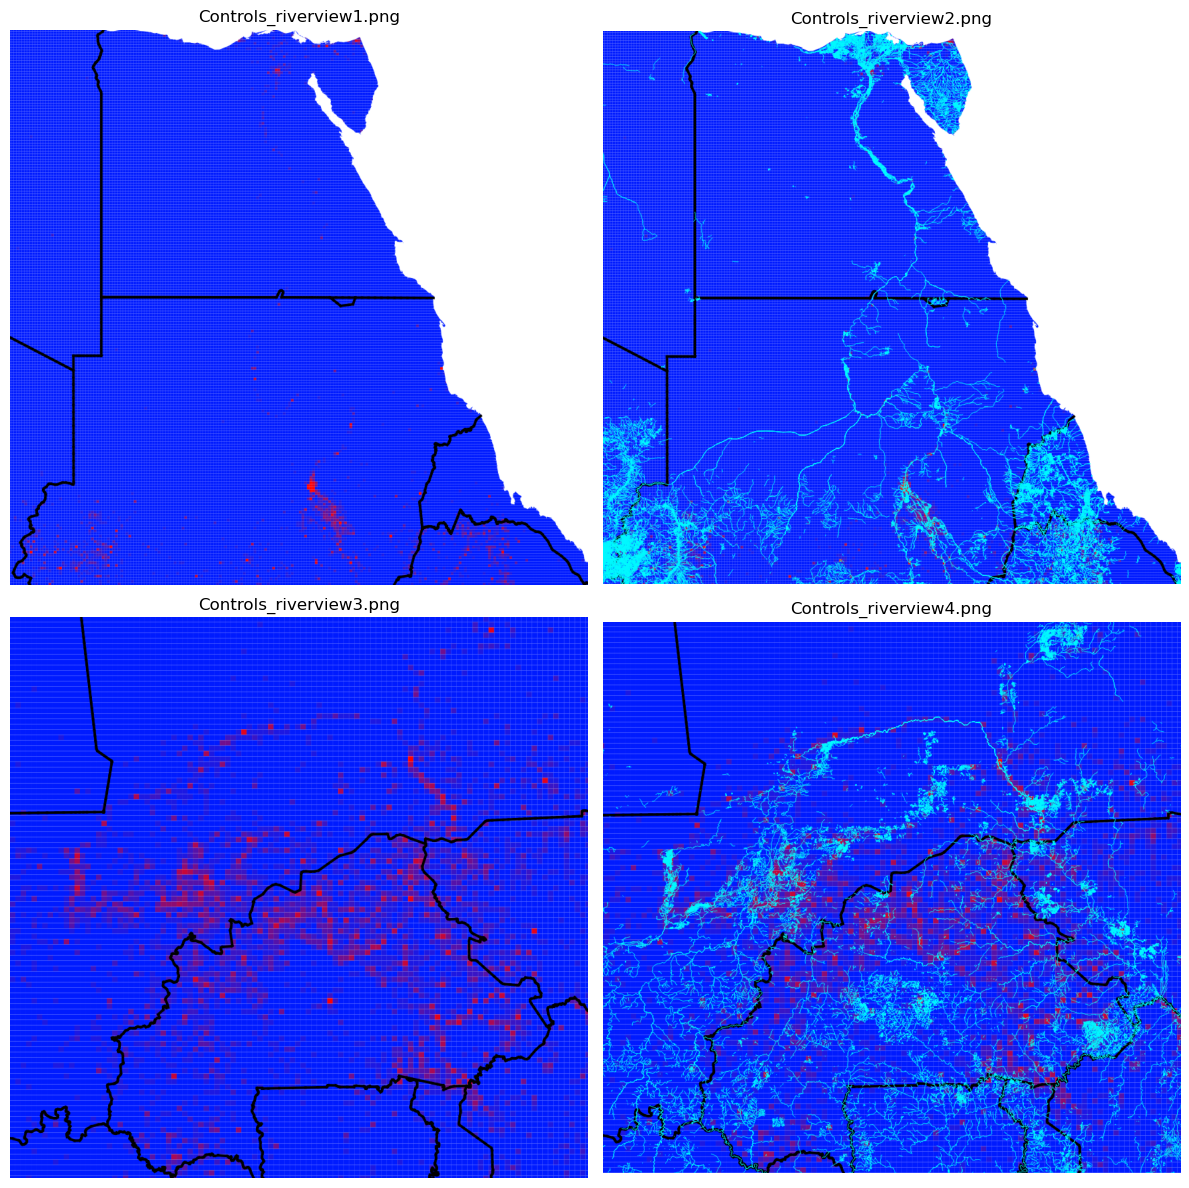

In [16]:
paths = ["screenshots/Controls_riverview1.png","screenshots/Controls_riverview2.png","screenshots/Controls_riverview3.png","screenshots/Controls_riverview4.png",]
imgs = [PILImage.open(p) for p in paths]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for ax, img, p in zip(axes, imgs, paths):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(p.split("/")[-1])
plt.tight_layout()
plt.show()


### "Bad Neighborhood" clusters

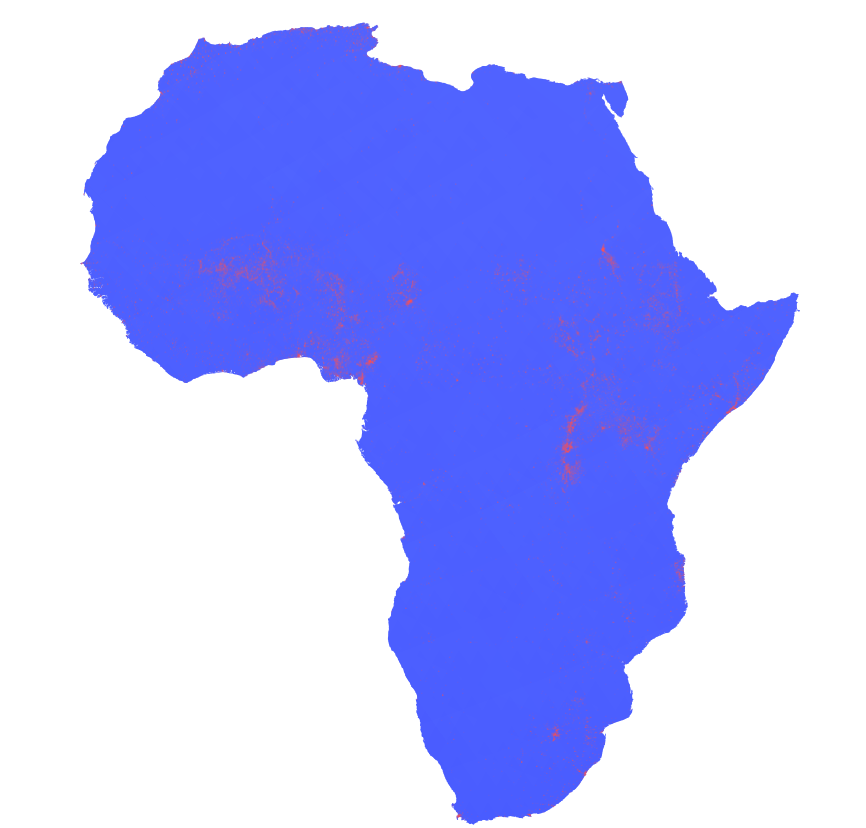

In [17]:
display(IPyImage(filename="screenshots/Count_violence_all.png"))